# Lecture 19:  Numerical Solutions to the Diffusion Equation  (Spectral Method)

## What to Learn?

* The assumptions of the spectral method
* The possible choices for basis vectors
* The linear independence of resulting ODEs
* One way to code the FFT/IFFT
* Finite differencing of the amplitudes
* Useful data structures and pointer swapping using tuples

## What to do?

* Solve the diffusion equation using a spectral method.
* Analyze two example implementations and determine the difference scheme.

### Introduction
----

In this course the term _spectral method_ refers to a numerical solution composed of a finite set of basis functions and the time evolution of their amplitudes.  Practically, the choice of basis functions will satisfy the boundary conditions and the initial amplitudes will satisfy the initial conditions.  The evolution of the amplitudes can then be written as a finite difference in time.  Although other choices for basis functions are [possible](./images/Boyd_Table.png)$^*$, we will focus on Fourier functions.

$*$ Chebyshev & Fourier Spectral Methods, Boyd, John P., Springer 1989

### Developing the Logic of the Spectral Method
----

The spectral method assumes that the solution to a PDE (the function $c(x,t)$) can be represented as a series expansion that contains time dependent amplitudes (the $a_k(t)$ factors) and spatially varying functions (the $\phi_k(x)$ terms are unit Fourier vectors).  Note the similarity to the approach taken in the separation of variables method in the following discussion.  

To begin, we write:

$$
c(x,t) = \sum_{k=0}^N a_k(t)\phi_k(x)
$$

Choosing the unit vectors from an orthonormal set (like Fourier) permits decoupling the summation into $N$ independent equations that can be solved simultaneously.  Furthermore, the assumption of the orthonormal set allows the time dependence to be placed within the amplitudes so that the independent variables are seperated.  Therefore we refer to the $a_k(t)$ as the set of amplitudes with one $a_k$ for each of the $k$-basis vectors, $\phi_k(x)$.  There is no restriction on the value of $N$ although practical considerations that relate to diffusive problems and the "smoothness" of the solutions will require just a few $N$ terms to achieve acceptable accuracy.  The form of $\phi$ depends on the problem being solved; the boundary conditions and the initial conditions will affect this choice.  

Our example problem:

$$
\frac{\partial c(x,t)}{\partial t} = \frac{\partial^2 c(x,t)}{\partial x^2}
$$

with the initial and boundary conditions:

$$
c(0,t) = 0\\
c(L,t) = 0\\
c(x,0) = c_0(x)
$$

The problem requires that our boundary values for the $c(x,t)$ at $0$ and $L$ are zero.  One possible choice is a series of $\sin$ terms.  This satisfies the boundary conditions and enforces perodicity of the solution.

$$
\phi_k(x) = \sin \left( \frac{k\pi x}{L} \right)
$$ 

Begin by importing relevant libraries and defining the symbols we expect to use.

In [1]:
import sympy as sp
x, y, z, t = sp.symbols('x y z t')
k, m, n = sp.symbols('k m n', integer=True)
f, g, h = sp.symbols('f g h', cls=sp.Function)
sp.var('a_k, phi, c', cls=sp.Function);
sp.var('L', real=True);
sp.init_printing();

The assumed form of the solution is:

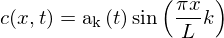

In [2]:
elementK = sp.Eq(c(x,t),a_k(t)*sp.sin(k*sp.pi*x/L))
elementK

In [3]:
sp.acos()

Proceed by substituting the series expansion into the PDE and performing the differentiations as defined:

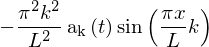

In [3]:
spaceDeriv = elementK.rhs.diff(x,2)
spaceDeriv

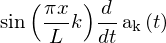

In [4]:
timeDeriv = elementK.rhs.diff(t,1)
timeDeriv

Our final differential equation represented in $a(t)$ is therefore:

$$
\sum_{k=0}^N \sin{\left (\frac{\pi x}{L} k \right )} \frac{d a_k{\left (t \right )}}{d t}  = - \sum_{k=0}^N \frac{\pi^{2} k^{2}}{L^{2}} a_k{\left (t \right )} \sin{\left (\frac{\pi x}{L} k \right )}
$$

As a reminder, a $\sin$ series is orthogonal over $0 < x < 2\pi$ if the following integral is zero:

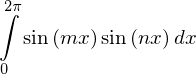

In [7]:
# m and n are symbols defined as integers
sinIntegral = sp.Integral(sp.sin(n*x)*sp.sin(m*x),(x,0,2*sp.pi))
sinIntegral

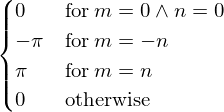

In [8]:
sinIntegral.doit()

Because the integral is zero for $m \neq n$, then the series on the LHS:

$$
\sum_{k=0}^N \sin{\left (\frac{\pi x}{L} k \right )} \frac{d a_k{\left (t \right )}}{d t}
$$

is a linear system.  This is also true for the RHS:

$$
- \sum_{k=0}^N \frac{\pi^{2} k^{2}}{L^{2}} a_k{\left (t \right )} \sin{\left (\frac{\pi x}{L} k \right )}
$$

The principle of superposition permits us to split this summation into N independent ordinary differential equations, solve each one, and then sum the solutions to produce the answer to the original PDE.  To continue developing a solution for these N independent ODEs it is necessary to analyze the amplitude ODE and define a differencing scheme.  This will be illustrated using SymPy:

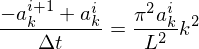

In [9]:
ai, aip1 = sp.symbols('a^{i}_k, a^{i+1}_k')
dt = sp.Symbol(r'\Delta t')

differenceEquation = sp.Eq((ai-aip1)/dt,((sp.pi**2*k**2*ai)/L**2))
differenceEquation

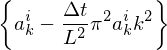

In [10]:
odeSolution = sp.solveset(differenceEquation,aip1)
odeSolution

The above solution results in the following difference scheme:

$$
a^{i+1}_k = a^{i}_k \left( 1 - \frac{\pi^{2} k^{2}}{L^{2}} \Delta t \right)
$$

The timestep, $dt$, should be chosen small enough such that the $a_k$ decay at each timestep.

### Implementation of the Spectral Method
----

An annotated implementation of the spectral method is developed in the next section.  Unlike the development above, we use the full Fourier series for the basis functions.  This is a basic implementation that could be improved with the addition of helper and visualization functions.  `SciPy` provides $\sin$ and $\cos$ transforms for other boundary conditions where Fourier may be inappropriate.

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

The following quantities are defined:

* `numPoints`: the number of points in the grid
* `L`: the total length of the domain
* `dt`:  the numerical timestep
* `steps`: the number of timesteps to compute
* `x`: a vector containing the x-position for each grid point in the domain from $0$ to $L$ with `numPoints` entries in the vector.

In [12]:
numPoints = 20
L = 1.0
dt = 0.0001
steps = 1000
# we have access to np.pi for $\pi$
x = np.linspace(0,L,numPoints)

The following vectors are defined:

* `c_new` will hold the $c(x,t)$ values at the start and end of the numerical computation
* `a_old` will hold the amplitudes at the current timestep (i.e. the $a^{i}_k$)
* `a_new` will hold the amplitudes at the next timestep (i.e. the $a^{i+1}_k$)

They are initalized to zero at the start of the calculation.  Each of these vectors is the same shape as `x` to hold the results of the FFT and IFFT.  They are declared as `complex128` to accomodate different initial conditions where the FFT would produce complex valued results.

In [13]:
c_new = np.zeros((numPoints), dtype='complex128')
a_old = np.zeros((numPoints), dtype='complex128')
a_new = np.zeros((numPoints), dtype='complex128')

In previous example calculations a set of basis vectors was created to illustrate Fourier transforms graphically and the terms in a Fourier series.  That is not part of this calculation, however this could be easily added if visualizing the results in more detail is desireable.

The difference equation requires values for the square of the Fourier numbers, $k^2$:

$$
a^{i+1}_k = a^{i}_k \left( 1 - \frac{\pi^{2} k^{2}}{L^{2}} \Delta t \right)
$$

To ensure appropriate matching between the $a_k(t)$ and $k$ the helper function `fftfreq()` is used.  Using `fftfreq` with `fft` and `ifft` ensures that the bookeeping of amplitudes and $k$ values is done correctly.  In the equation for the time rate of change in the amplitudes there is a constant $k^2$ term - computing this first avoids having to repeatedly compute the quantity each time step.

`NumPy` arrays are called by reference so it is necessary to perform an element-by-element "deep copy" of the data from one array into another array when building the initial condition. The helper function `np.copyto` provides this capability.  `a_new` is then filled with the amplitudes corresponding to the initial condition.

In [14]:
k = np.fft.fftfreq(numPoints, d=L/(numPoints-1))
k2 = k**2
initialCondition = np.sin(np.pi*x/L)

# create an initial condition (this could be a simple function like x**2)
np.copyto(c_new, initialCondition)
# transform it (dft or sin transform)
np.copyto(a_new,np.fft.fft(c_new))

Instabilities will occur if the amplitudes do not decay at each timestep.  The problem is that the condition depends on the wavenumber - so a suitable $\Delta t$ must be chosen that satisfies the most restrictive condition for the largest wavenumber.  Using a Boolean expression it is possible to check to see if all of the wavenumbers result in a factor less than one:

In [15]:
(dt*np.pi**2*k2)/L**2 < 1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

If any the results are `False` then the numerical calculation will not converge, if they are all `True` then it is possible to complete the numerical calculation.  The next code block performs the numerical iterations of the amplitudes.  First the pointers to `a_new` and `a_old` are swapped and then `a_new` is filled with the new values based on the `a_old` values.  This sequence of operations is performed for the number of timesteps given in `steps`:

In [21]:
for i in range(steps):
    # swap pointers
    a_new, a_old = a_old, a_new
    # find new amplitudes
    np.copyto(a_new, a_old*(1-(dt*np.pi**2*k2)/L**2))

When the requested number of steps have been computed, we use the inverse Fourier transform to compute the concentration profile and store those results in `c_new`:

In [17]:
# inverse transform it
np.copyto(c_new, np.fft.ifft(a_new))

After the computation, the concentration profile are displayed with a helper function:

In [19]:
def makePlot():
    fig = plt.figure()
    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)
    axes.plot(x, c_new.real, 'r')
    # Setting the y-limit cleans up the plot.
    axes.set_ylim([0.0,1.0])
    axes.set_xlabel('Distance $x$')
    axes.set_ylabel('Concentration $c(x,t)$')
    axes.set_title('Concentration Profile solved by Spectral Method')
    plt.show()
    return

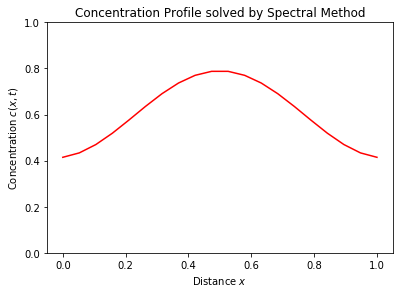

In [20]:
makePlot()

Another solution scheme could preserve the values of the concentration.  I choose not to do that here for simplicity.  Doing so would permit a small animation of the diffusion process, however.  This is left to the student to implement.

### Reading Assignments and Practice
----

Analyze the spectral difference schemes in the following two examples.  For reference and attribution the codes can be found [here](https://open.umich.edu/find/open-educational-resources/literature-science-arts/parallel-spectral-numerical-methods).  The materials are provided under a Creative Commons license with attribution to the original authors whose names can be found at the above link.

In [ ]:
# %load Heat_Eq_1D_Spectral_BE.py
#!/usr/bin/env python
"""
Solving Heat Equation using pseudospectral methods with Backwards Euler:
u_t= \alpha*u_xx
BC = u(0)=0 and u(2*pi)=0 (Periodic)
IC=sin(x)
"""

import math
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# Grid
N = 64; h = 2*math.pi/N; x = [h*i for i in xrange(1,N+1)]

# Initial conditions
v = [math.sin(y) for y in x]
alpha = 0.5
t = 0     
dt = .001 #Timestep size

# (ik)^2 Vector
I = complex(0,1)
k = numpy.array([I*n for n in range(0,N/2) + [0] + range(-N/2+1,0)])
k2=k**2;

# Setting up Plot
tmax = 5.0; tplot = 0.1
plotgap= int(round(tplot/dt))
nplots = int(round(tmax/tplot))
data = numpy.zeros((nplots+1,N))
data[0,:] = v
tdata = [t]

for i in xrange(nplots):
    v_hat = numpy.fft.fft(v)  # convert to fourier space
    for n in xrange(plotgap):
        v_hat = v_hat / (1-dt*alpha*k2) # backward Euler timestepping

    v = numpy.fft.ifft(v_hat)   # convert back to real space
    data[i+1,:] = numpy.real(v)   # records data

    t = t+plotgap*dt    # records real time
    tdata.append(t)

# Plot using mesh
xx,tt = (numpy.mat(A) for A in (numpy.meshgrid(x,tdata)))

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xx, tt, data,rstride=1, cstride=1, cmap=cm.jet,
        linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.xlabel('x')
plt.ylabel('t')
plt.show()

In [ ]:
# %load Heat_Eq_1D_Spectral_FE.py
#!/usr/bin/env python
"""
Solving Heat Equation using pseudo-spectral and Forward Euler
u_t= \alpha*u_xx
BC= u(0)=0, u(2*pi)=0
IC=sin(x)
"""

import math
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# Grid
N = 64                     # Number of steps
h = 2*math.pi/N                 # step size
x = h*numpy.arange(0,N)    # discretize x-direction

alpha = 0.5                # Thermal Diffusivity constant
t = 0
dt = .001

# Initial conditions 
v = numpy.sin(x)
I = complex(0,1)
k = numpy.array([I*y for y in range(0,N/2) + [0] + range(-N/2+1,0)])
k2=k**2;

# Setting up Plot
tmax = 5; tplot = .1;
plotgap = int(round(tplot/dt))
nplots  = int(round(tmax/tplot))

data = numpy.zeros((nplots+1,N))
data[0,:] = v
tdata = [t]

for i in xrange(nplots):
    v_hat = numpy.fft.fft(v)

    for n in xrange(plotgap):
        v_hat = v_hat+dt*alpha*k2*v_hat # FE timestepping

    v = numpy.real(numpy.fft.ifft(v_hat))   # back to real space
    data[i+1,:] = v

    # real time vector
    t = t+plotgap*dt
    tdata.append(t)

# Plot using mesh
xx,tt = (numpy.mat(A) for A in (numpy.meshgrid(x,tdata)))

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xx, tt, data,rstride=1, cstride=1, cmap=cm.jet,
        linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.xlabel('x')
plt.ylabel('t')
plt.show()